In [54]:
import scipy
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [2]:
def Stroke_closing(img):
    # used to close stroke prediction image
    new_img = np.zeros_like(img)
    new_img = scipy.ndimage.morphology.binary_closing(img, structure=np.ones((2,2,2)))
    return new_img

In [3]:
def get_MaskNet_MNI(model, Dwi_MNI_img, B0_MNI_img):
    # To inference brain mask from MaskNet model
    # model specifies which pre-trained DL model is used to inference
    # Dwi_MNI_img and B0_MNI_img are input images in MNI domain
    
    # Down sampling
    dwi = Dwi_MNI_img[0::4,0::4,0::4,np.newaxis] # Down sample for MaskNet, dim should be [48, 56, 48, 1]

    b0 = B0_MNI_img[0::4,0::4,0::4, np.newaxis] # Down sample for MaskNet, dim should be [48, 56, 48, 1]
    x = np.expand_dims(np.concatenate((dwi,b0),axis=3), axis=0)

    # inference
    y_pred = model.predict(x, verbose=0)
    y_pred = (np.squeeze(y_pred)>0.5)*1.0

    
    # the following is post processing of predicted mask by 
    # 1) selecting the major non-zero voxel
    # 2) closing
    # 3) binary fill holes
    # 4) upsampling to high resolution space by (4,4,4)
    
    mask_label, num_features = scipy.ndimage.label(y_pred)
    dilate_mask = (mask_label == scipy.stats.mode(mask_label[mask_label>0].flatten(), keepdims=True)[0][0])*1
    dilate_mask = Stroke_closing(dilate_mask)
    dilate_mask = scipy.ndimage.morphology.binary_fill_holes(dilate_mask)
    upsampling_mask = np.repeat(np.repeat(np.repeat(dilate_mask, 4, axis=0), 4, axis=1), 4, axis=2)

    return upsampling_mask

In [55]:
MaskNet_name =  os.path.join("D:\ADS_Algorithm\ADSv1.3\data\Trained_Nets", 'BrainMaskNet.h5')

In [57]:
MaskNet = load_model(MaskNet_name, compile=False)

In [ ]:
mask_MNI_img = get_MaskNet_MNI(MaskNet, Dwi_MNI_img, B0_MNI_img)
mask_raw_img = affine_map.transform_inverse((mask_MNI_img>0.5)*1, interpolation='nearest')
mask_raw_img = (mask_raw_img>0.5)*1.0

if generate_brainmask:
    mask_raw_ImgJ = get_new_NibImgJ(mask_raw_img, Dwi_imgJ, dataType=np.int16)
    nib.save(mask_raw_ImgJ, os.path.join(SubjDir, SubjID + '_Mask.nii.gz'))

In [97]:
nii_dwi_img = nib.load("D:\\pythonscripts_ETIS\\2018-104_01-10087-D0MR_12_SWI_Images_swi3d1r_Normalized.nii.gz")
nii_dwi_data = nii_dwi_img.get_fdata()

In [98]:
nii_dwi_data.shape

(192, 224, 192)

In [99]:
dwi = nii_dwi_data[0::4,0::4,0::4,np.newaxis] # Down sample for MaskNet, dim should be [48, 56, 48, 1]

In [100]:
dwi.shape

(48, 56, 48, 1)

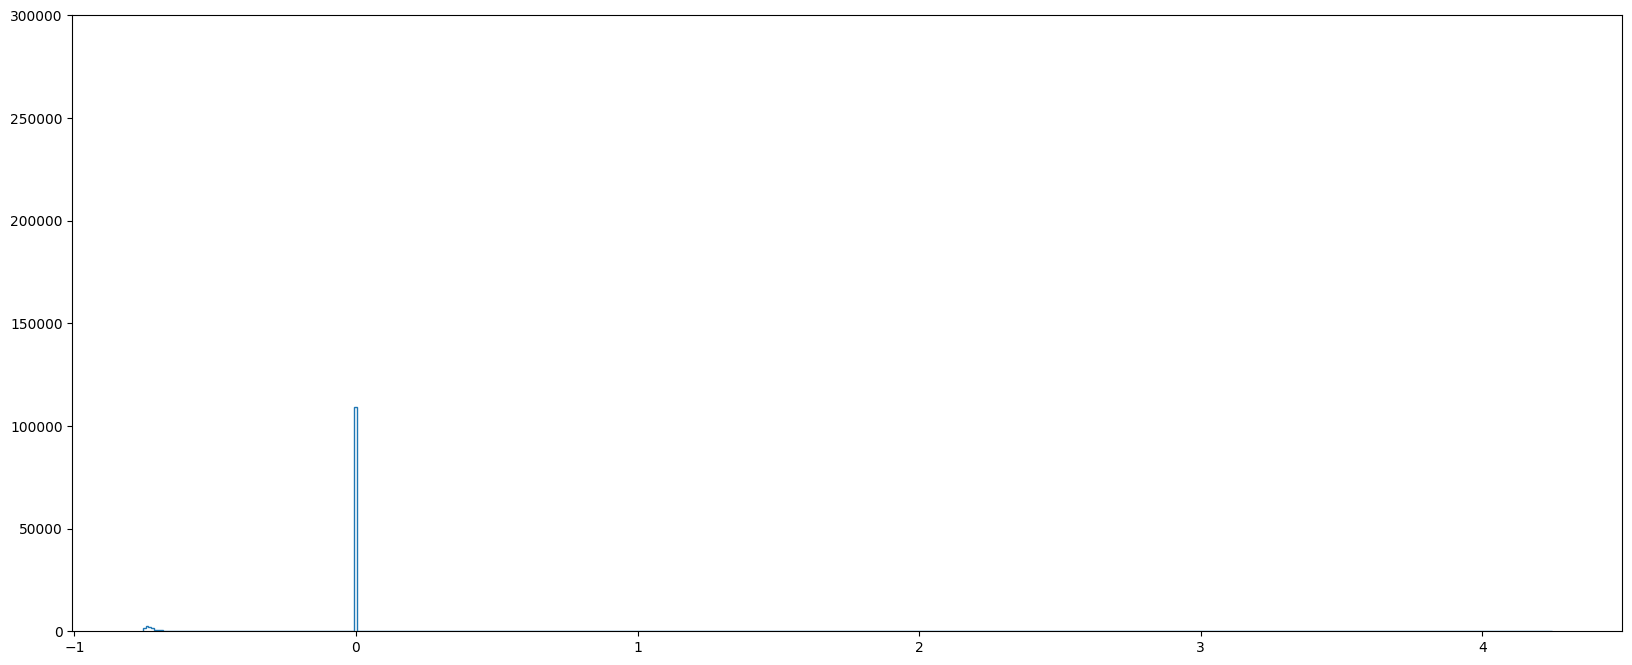

In [101]:
fig, ax = plt.subplots(figsize=(20, 8))
counts, bins = np.histogram(dwi.flatten(), bins=500)

plt.hist(bins[:-1], bins, weights=counts, histtype="step")
ax.set_ylim(0,300000)
plt.show()

In [45]:
nii_b0_img = nib.load("D:\\pythonscripts_ETIS\\2018-104_01-10087-D0MR_8_TOF_3D_NEW_wo_ARTEFACTS_fl3d1r_t50_Normalized.nii.gz")
nii_b0_data = nii_b0_img.get_fdata()

In [87]:
ref_img = nib.load("D:\\ADS_Algorithm\\ADSv1.3\\data\\examples\\Subject01\\Subject01_b0_MNI.nii.gz")
ref_img_data = ref_img.get_fdata()

In [88]:
ref = ref_img_data[0::4,0::4,0::4, np.newaxis]

In [89]:
ref_img_data.shape

(181, 217, 181)

In [90]:
ref.shape

(46, 55, 46, 1)

In [47]:
b0 = nii_b0_data[0::4,0::4,0::4, np.newaxis] # Down sample for MaskNet, dim should be [48, 56, 48, 1]

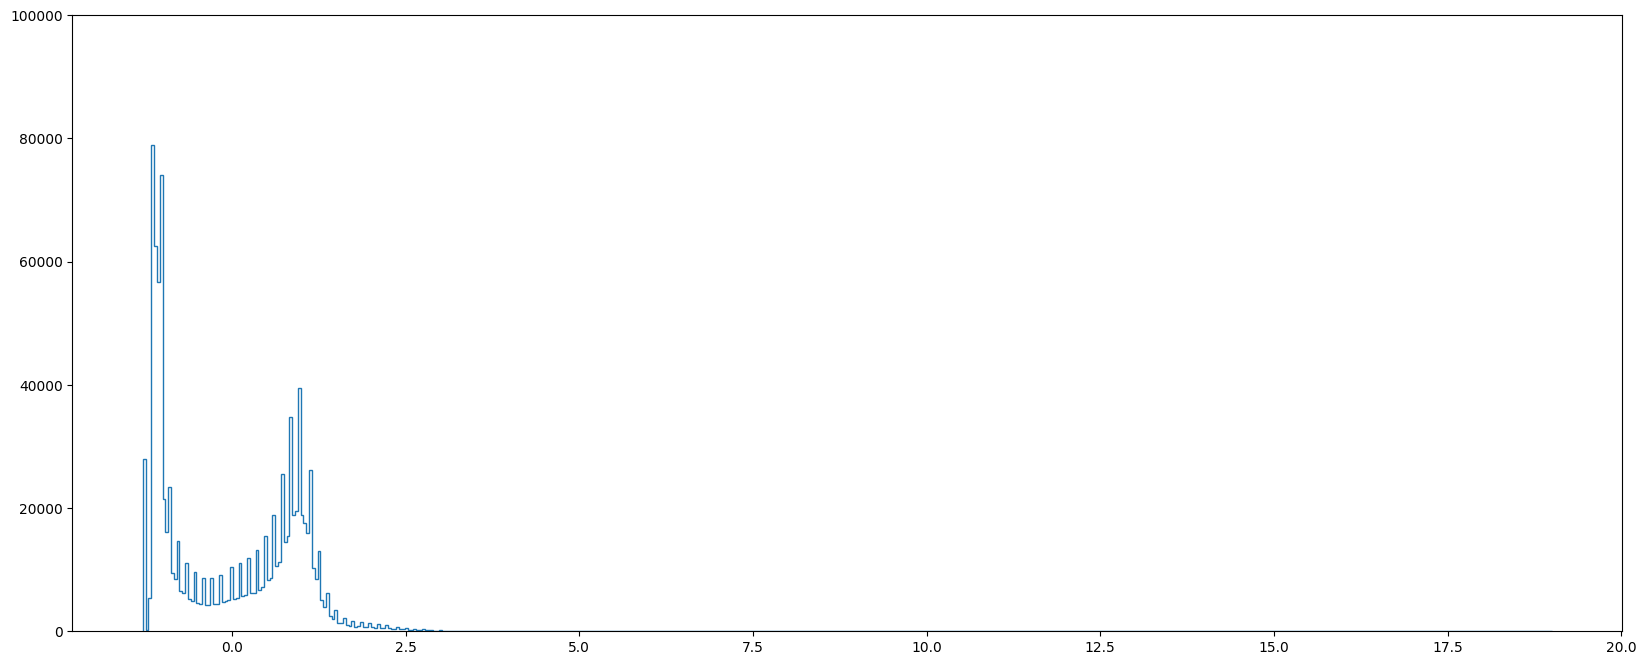

In [48]:
fig, ax = plt.subplots(figsize=(20, 8))
counts, bins = np.histogram(b0.flatten(), bins=500)

plt.hist(bins[:-1], bins, weights=counts, histtype="step")
ax.set_ylim(0,100000)
plt.show()

In [49]:
x = np.expand_dims(np.concatenate((dwi,b0),axis=3), axis=0)

In [58]:
y_pred = MaskNet.predict(x, verbose=0)

ValueError: in user code:

    File "C:\Users\wijflo\tensorflow_gpu_env\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\wijflo\tensorflow_gpu_env\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\wijflo\tensorflow_gpu_env\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\wijflo\tensorflow_gpu_env\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "C:\Users\wijflo\tensorflow_gpu_env\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\wijflo\tensorflow_gpu_env\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_1" is incompatible with the layer: expected shape=(None, 48, 56, 48, 2), found shape=(None, 164, 192, 32, 2)
